In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from aicsimageio import AICSImage as imio
from alive_progress import alive_bar
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
sourcepath = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\stack\\stack_MMStack_Default.ome.tif"

# Rough explanation
## Loaded raw images are processed as follows:
#### Temporary placeholder figure is set up
### Stack operations (proc_img)
#### Stack M(in)IP for background subtraction (optional)
#### Squaring (optional)
### Slice operations
#### Use selection of squaring or power dependent gaussian on 2D background-subtracted slice
#### Take either the maximum, mean or minimum intensity projection or the top n% of pixels along the projection direction
### Line operations
#### Apply S-G or median filter
#### Optionally do FFT, or just get a peak number of pixels for an intensity measurement
#### Obtain the roots to get FWHM or just use the intensity measurement
### Graph results
#### Allow for batch processing as well

In [3]:
#Load ops
data_ref = imio(sourcepath).data
n_slices = data_ref.shape[2]

<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304


# General functions

In [4]:
def rescale(np_arr_in,new_min,new_max):
    rescaled = ((new_max-new_min)*(np_arr_in-np.min(np_arr_in))/((np.max(np_arr_in)-np.min(np_arr_in))))+new_min
    return rescaled

# Stack functions

In [5]:
def lazy_project(method,data_ref):
    all_slices = range(n_slices)
    running_img = getslice(0)
    with alive_bar(n_slices,force_tty=True, title = "Lazy projecting...") as proj_progbar:
        for slice in all_slices:
            this_slice = getslice(slice)
            match method:
                case "min":
                    running_img = np.minimum(this_slice,running_img)
                case "max":
                    running_img = np.maximum(this_slice,running_img)
                case "mean":
                    running_img = running_img+this_slice
                case "sum":
                    running_img = running_img+this_slice
            proj_progbar()
        if(method=="mean"):
            running_img = running_img/n_slices
    return running_img

# Slice functions

In [6]:
def getslice(slicenum):
    return np.squeeze(data_ref[0,0,slicenum,:,:]).astype(float)

In [7]:
def project(method, which_axis, data):
    proj = None
    dirn = 0
    match which_axis:
        case "X":
            dirn = 0
        case "Y":
            dirn = 1
        case _:
            dirn = 0
    match method:
        case "min":
            proj = np.min(data,axis=dirn)
        case "max":
            proj = np.max(data,axis=dirn)
        case "mean":
            proj = np.mean(data,axis=dirn)
        case "sum":
            proj = np.sum(data,axis=dirn)
        case "top 50":
            num_pixels = 50
            sorted = np.sort(data,kind='mergesort',axis=dirn)
            if(dirn>0):
                sorted = np.transpose(sorted)
            sorted = sorted[0-num_pixels:]
            proj = np.mean(sorted,axis=0)
        
    return proj.astype(float)

# Line functions

In [8]:
def getroots(vect):
    peak = max(vect)
    vall = min(vect)
    spline = sp.interpolate.UnivariateSpline(np.arange(0,int(len(vect)),1), vect-((peak+vall)/2), s=0)
    roots = spline.roots()
    return np.min(roots),np.max(roots)

# Analysis functions

In [9]:
def setup_plot():
    # Setup for live plot
    fig_1 = plt.figure(figsize=(15,4))
    f_1A = fig_1.add_subplot(1,3,1)
    tmp_img = getslice(0)
    imgpixels_ref = f_1A.imshow(tmp_img,cmap='gray',vmin=0,vmax=np.max(tmp_img))
    n_y_px,n_x_px = tmp_img.shape[0],tmp_img.shape[1]
    scaling_frac = 0.4
    
    scaled_x_profile = rescale(project("max","X",tmp_img),0,scaling_frac*n_x_px)
    scaled_y_profile = rescale(project("max","Y",tmp_img),0,scaling_frac*n_y_px)
    xplt, = f_1A.plot(scaled_x_profile,color='r')
    #Little fudge to get the plot along y-x, not x-y
    yplt, = f_1A.plot(scaled_y_profile,color='b')
    extra_line, = f_1A.plot([0,0],color='g')
    newy = yplt.get_xdata()
    newx = yplt.get_ydata()
    yplt.set_xdata(newx)
    yplt.set_ydata(newy)
    
    #Setup for processed plot
    f_1B = fig_1.add_subplot(1,3,2)
    f_1B.set_xlim(0,n_slices-1)
    f_1B.set_xlabel("Slice")
    f_1B.set_ylabel("Normalised metric value")
    slice_indicator = f_1B.axvline(0,0,1,linestyle=":")
    proc_method="Evaluations"
    f_1B.set_title(proc_method)
    return [f_1A,f_1B,imgpixels_ref,xplt,yplt,extra_line,slice_indicator]

In [10]:
stored_bg = lazy_project("min",data_ref)

Lazy projecting... |████████████████████████████████████████| 51/51 [100%] in 1.


In [11]:
def filt_SG(line_in,scale):
    filtered_line = sp.ndimage.uniform_filter1d(line_in,size=scale, mode='nearest')
    return filtered_line

def filt_median(line_in,scale):
    filtered_line = proj_line = sp.signal.medfilt(line_in,scale)
    return filtered_line

def take_FFT(line_in):
    filtered_line = np.roll(np.abs(np.fft.fft(line_in)),int(len(line_in)/2))
    return filtered_line

In [12]:
def proc_img(settings_info,bg_sub,square_px,raw_image):
    output_image = raw_image
    if(bg_sub):
        output_image = raw_image-stored_bg
        settings_info = settings_info+"bgsub, "
    if(square_px):
        output_image = output_image*output_image
        settings_info+="img sq, "
    
    return settings_info,output_image

In [13]:
def proc_line(img_to_process,settings_info,method,square_ln,metric_target_axis,filt_scale,filt_type,percent_to_evaluate,line_smoothing,do_FFT_on_lines,suppress_FFT_spike):
    output_image = img_to_process
    settings_info+=" proj_on "+metric_target_axis+",\n"
    raw_x_profile = project(method,"X",output_image)
    raw_y_profile = project(method,"Y",output_image)
    processed_x = raw_x_profile 
    processed_y = raw_y_profile
    
    if(square_ln):
        processed_x = processed_x*processed_x
        processed_y = processed_y*processed_y
        settings_info+="ln sq, "

    ### Add aspect ratio for x and y filters? Not necessary for metric evaluation though
    if(filt_scale>0):
        match filt_type:
            case "Savitzky-Golay":
                processed_x = filt_SG(processed_x,filt_scale)
                processed_y = filt_SG(processed_y,filt_scale)
            case "Median":
                processed_x = filt_median(processed_x,filt_scale)
                processed_y = filt_median(processed_y,filt_scale)
            case "S-G then median":
                processed_x = filt_SG(processed_x,filt_scale)
                processed_x = filt_median(processed_x,filt_scale)
                processed_y = filt_SG(processed_y,filt_scale)
                processed_y = filt_median(processed_y,filt_scale)
        settings_info+=filt_type+", scale "+str(filt_scale)+", "

    extra_vals = None
    
    if(do_FFT_on_lines):
        settings_info+="\nFFT"
        if(metric_target_axis == "X"):
            extra_vals = take_FFT(processed_x)
        else:
            extra_vals = take_FFT(processed_y)
        if(suppress_FFT_spike):
            extra_vals = filt_median(extra_vals,5)
            settings_info+="(supp)"
        settings_info+=", "
    
    return settings_info,processed_x,processed_y,extra_vals

In [14]:
def eval_metric(settings_info,line_in,metric_evaluation,percent_to_evaluate):
    metric = None
    match metric_evaluation:
        case "Extreme roots":
            min,max = getroots(line_in)
            metric = max-min
        case "stdev of line":
            metric = np.std(line_in)
        case "Peak of line":
            metric = np.max(line_in)
        case "% of highest":
            settings_info+=str(percent_to_evaluate)
            sorted = -np.sort(-line_in,kind='mergesort')#The - signs are to fudge descending order
            num_to_check = int(line_in.size * (percent_to_evaluate/100))
            metric = np.mean(sorted[0:num_to_check])
    settings_info+=" eval: "+metric_evaluation
    return settings_info, metric

In [15]:
def proc_slice(slicenum,method,square_px,square_ln,autoscale_img,bg_sub,metric_target_axis,filt_scale,filt_type,metric_evaluation,percent_to_evaluate,line_smoothing,do_FFT_on_lines,suppress_FFT_spike):
    profile_01 = None
    profile_02 = None
    metric_value = None
    scaling_frac = 0.4
    
    settings_info = method+" proj, "

    # Image level operations ===========================================================================
    output_image = raw_image = getslice(slicenum)
    n_x_px = output_image.shape[0]
    n_y_px = output_image.shape[1]
    settings_info,output_image = proc_img(settings_info,bg_sub,square_px,raw_image)

    # Profile level operations =========================================================================
    settings_info, x_profile, y_profile, extra_profile = proc_line(output_image, settings_info, method, square_ln, metric_target_axis, filt_scale, filt_type, percent_to_evaluate, line_smoothing, do_FFT_on_lines, suppress_FFT_spike)

    # Metric evaluation ================================================================================
    line_to_eval = None
    if(do_FFT_on_lines):
        line_to_eval = extra_profile
    else:
        if(metric_target_axis=="X"):
            line_to_eval = x_profile
        else:
            line_to_eval = y_profile
    settings_info, metric_value = eval_metric(settings_info, line_to_eval, metric_evaluation, percent_to_evaluate)

    # Display operations ===============================================================================
    scaled_x_profile = rescale(x_profile,0,scaling_frac*n_x_px)
    scaled_y_profile = rescale(y_profile,0,scaling_frac*n_y_px)
    xplt.set_ydata(scaled_x_profile)
    yplt.set_xdata(scaled_y_profile)

    if(extra_profile is None):
        extra_profile = np.zeros(n_x_px)
    if(extra_profile.size == imgpixels_ref.get_array().shape[0]):
        #Along X
        extra_line.set_ydata(range(imgpixels_ref.get_array().shape[0]))
        extra_line.set_xdata(rescale(extra_profile,0,scaling_frac*n_y_px))
    else:
        #Along Y
        extra_line.set_xdata(range(imgpixels_ref.get_array().shape[1]))
        extra_line.set_ydata(rescale(extra_profile,0,scaling_frac*n_x_px))
    
    imgpixels_ref.set_array(output_image)
    f_1A.set_title(settings_info)
    slice_indicator.set_data([slicenum],[0,1])
    if(autoscale_img == True):
        imgpixels_ref.set_clim(np.min(output_image),np.max(output_image))
    plt.draw()
    
    return output_image, profile_01, profile_02, metric_value, settings_info

GridspecLayout(children=(IntSlider(value=25, description='Slice', layout=Layout(grid_area='widget001'), max=50…

Output()

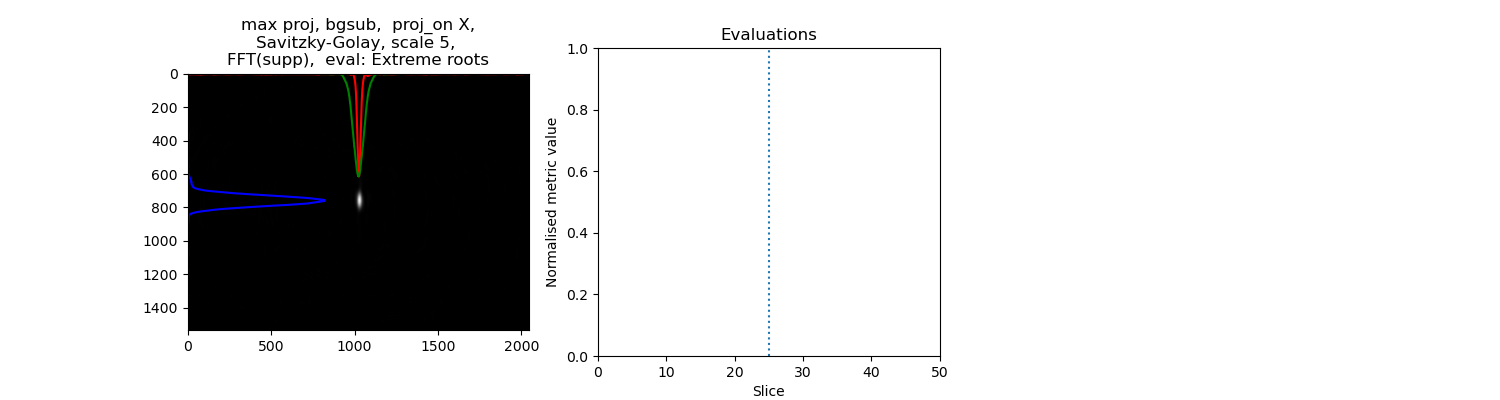

In [16]:
%matplotlib widget

# Define some defaults ===========================================================
arb_max = 101

f_1A,f_1B,imgpixels_ref,xplt,yplt,extra_line,slice_indicator = setup_plot()

# Declare controls ===============================================================
slicenum = widgets.IntSlider(description="Slice", min=0, max=n_slices-1, value=25)
proj_meth = widgets.Dropdown(options=["max","min","mean","top 50"], description='Method')
square_img = widgets.Checkbox(False, description='Square raw img')
square_ln = widgets.Checkbox(False, description='Square projection')
bg_sub = widgets.Checkbox(True, description='Subtract background')
scale_it = widgets.Checkbox(True, description='Scale display intensity')
targ_ax = widgets.Dropdown(options=["X","Y"], description='Metric axis')
filt_scale = widgets.IntSlider(description="Filter scale", min=-1, max=arb_max, value=5, step = 2)
filt_type = widgets.Dropdown(options=["Savitzky-Golay","Median","S-G then median"], description='Filter type')
do_FFT = widgets.Checkbox(True, description='Do FFT on lines')
suppress_FFT_spike = widgets.Checkbox(True, description='Suppress FFT spike')
metric_evaluation = widgets.Dropdown(options=["Extreme roots","stdev of line", "Peak of line", "% of highest"], description='Metric evaluation method')
eval_pct = widgets.FloatSlider(description="% of line to consider", min=0.1, max=5, step=0.1, value=-0.2, readout_format='.1f')
line_smoothing = widgets.Dropdown(options=["As set here","Adaptive", "None"], description='Line smoothing method')# - IMPLEMENTATION TBD - FIX THIS
run_proc = widgets.Button(description = 'Process all slices')
clear_disp = widgets.Button(description = 'Clear graphs')

# Arrange controls ===============================================================
nrows = 4
ncols = 4
control_list = [slicenum, proj_meth, square_img, square_ln, filt_scale, filt_type, bg_sub, scale_it, eval_pct, metric_evaluation, do_FFT, suppress_FFT_spike, run_proc,targ_ax, clear_disp]
grid = widgets.GridspecLayout(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        if((ncols*i)+j<len(control_list)):
            grid[i, j] = control_list[(ncols*i)+j]
ui = grid

# Define button actions ==========================================================
@run_proc.on_click
def run_clicked(run_proc):
    with alive_bar(n_slices,force_tty=True, title = "Processing metric") as metric_progbar:
        metric = []
        for slice in range(n_slices):
            output_image, profile_01, profile_02, metric_value, settings_info = proc_slice(slice,proj_meth.value,square_img.value,square_ln.value,scale_it.value,bg_sub.value,targ_ax.value,filt_scale.value,filt_type.value,metric_evaluation.value,eval_pct.value,line_smoothing.value,do_FFT.value,suppress_FFT_spike.value)
            metric.append(metric_value)
            metric_progbar()
        scaled_metric = (metric - np.min(metric)) / (np.max(metric) - np.min(metric))
        f_1B.plot(scaled_metric,label=settings_info)
        f_1B.legend(loc='center right', bbox_to_anchor=(2.2, 0.5))

@clear_disp.on_click
def clear_clicked(clear_disp):
    f_1B.cla()
    f_1B.set_title("Evaluations")
    f_1B.set_xlabel("Slice")
    f_1B.set_ylabel("Normalised metric value")
    slice_indicator = f_1B.axvline(0,0,1,linestyle=":")

# Show controls and interact ======================================================
out = widgets.interactive_output(proc_slice, {'slicenum': slicenum, 'method': proj_meth, 'square_px':square_img, 'square_ln':square_ln, 'autoscale_img':scale_it, 'bg_sub':bg_sub, 'metric_target_axis':targ_ax, 'filt_scale':filt_scale, 'filt_type':filt_type, 'metric_evaluation':metric_evaluation, 'percent_to_evaluate':eval_pct, 'line_smoothing':line_smoothing, 'do_FFT_on_lines':do_FFT, 'suppress_FFT_spike':suppress_FFT_spike})
display(ui, out)